In [ ]:
!pip install tqdm-joblib
!python -m pip install -U scikit-image

In [357]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix,graycoprops
from google.colab.patches import cv2_imshow
from multiprocessing import Pool
import tqdm
from skimage.util.shape import view_as_windows
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib
from sklearn.cluster import KMeans
from skimage.transform import rescale
from sklearn.feature_extraction import image
from sklearn.preprocessing import MinMaxScaler

In [358]:
def load_data(img):
  img = cv2.imread(img,1)
  img = cv2.resize(img, (0, 0), fx = 0.3, fy = 0.3)
  gray_image = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
  scaled_gray_image = (rescale(gray_image, 1, anti_aliasing=False)*25).astype('uint8')
  return scaled_gray_image

In [359]:
def show_hist(image):
  # computing the histogram of the blue channel of the image
  hist = cv2.calcHist([image],[0],None,[256],[0,256])
    
  # plot the above computed histogram
  plt.plot(hist, color='b')
  plt.title('Image Histogram For Blue Channel GFG')
  plt.show()

In [360]:
def glcm_props(patch , neigh , angle):
    lf = []
    props = ['dissimilarity',  'contrast', 'homogeneity', 'energy', 'correlation']
    glcm = graycomatrix(patch, neigh, angle,levels=26, symmetric=True, normed=True)

    for f in props:
      for item in graycoprops(glcm, f):
        lf.extend( item )
        
    return np.asarray(lf)

In [364]:
def compute_props(scaled_gray_image):
  # number of processes
  nprocs = 10
  patch_sizes = [ 11 , 21 , 25 , 31 ]
  angles = [0 , np.pi/4 , np.pi/2,3*np.pi/4]
  neighs = [3 , 5 , 7]

  results = []
  for size in patch_sizes:
    PATCH_SIZE = (size , size)
    patches = image.extract_patches_2d(scaled_gray_image, PATCH_SIZE)

    result = []
    title = "Calculation for patch size : " + str(size)
    with tqdm_joblib(desc=title , total=patches.shape[0]) as progress_bar:
      result.extend(Parallel(n_jobs=nprocs)(delayed(glcm_props)(patch,neighs,angles) for patch in patches))
    results.append(result)

  return results

In [367]:
def compute_algo(img , k):
  patch_sizes = [ 10 , 20 , 24 , 30 ]

  img = load_data(img)
  w , h = img.shape[0] , img.shape[1]

  show_hist(img)

  results = np.asarray(compute_props(img))
  
  for i , item in enumerate(results):
    scaler = MinMaxScaler().fit_transform(item)
    kmeans = KMeans(n_clusters=k).fit(scaler)
    labels = kmeans.fit_predict(scaler).reshape(w-patch_sizes[i] , h-patch_sizes[i])
    plt.imshow(labels)
    plt.show()


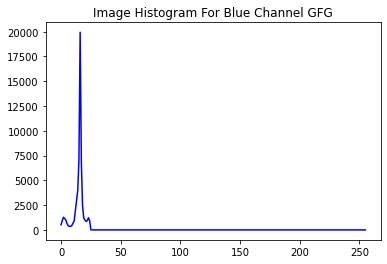

Calculation for patch size : 31: 100%|██████████| 45900/45900 [00:55<00:00, 830.54it/s]
<ipython-input-365-5ab2d01598b2>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results = np.asarray(compute_props(img))


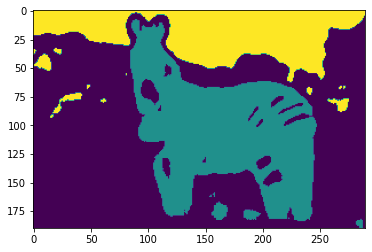

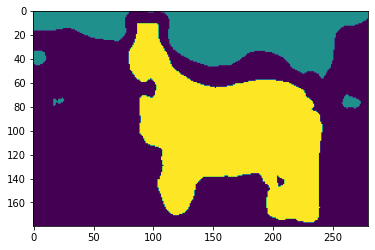

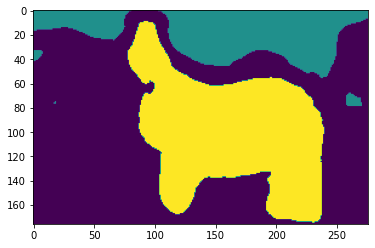

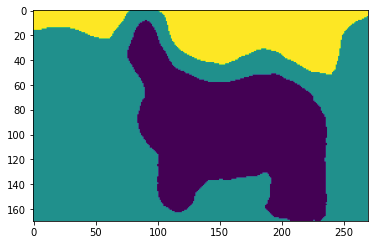

In [366]:
res = compute_algo("img1.jpg" , 3)

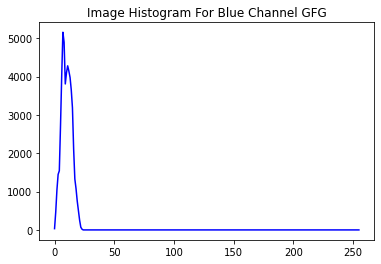

Calculation for patch size : 31: 100%|██████████| 41250/41250 [00:42<00:00, 965.53it/s] 
<ipython-input-367-d8c1f9d04c5b>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results = np.asarray(compute_props(img))


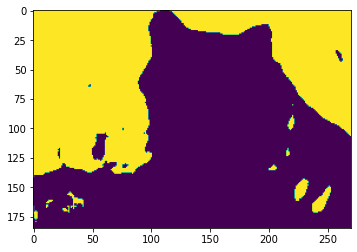

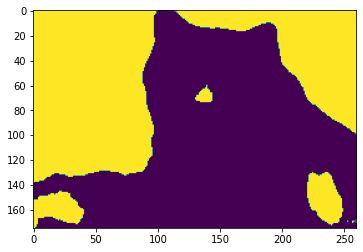

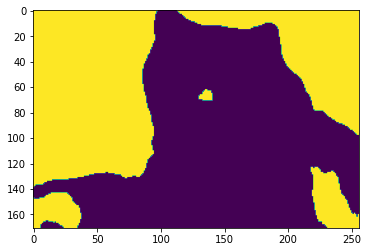

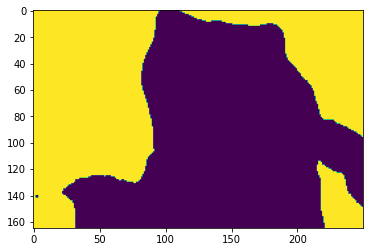

In [368]:
res = compute_algo("img2.jpg" , 2)